# Image Classification

In this project, you'll classify images from the CIFAR-10 dataset
(https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other
objects. You'll preprocess the images, then train a convolutional neural network on all the samples.
The images need to be normalized and the labels need to be one-hot encoded. You'll get to apply
what you learned and build a convolutional, max pooling, dropout, and fully connected layers. At the
end, you'll get to see your neural network's predictions on the sample images.

In [1]:
!pip install -q tqdm

In [2]:
#@title Default title text
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import math

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [08:12, 346kB/s]                                       


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)   #reshaping each image into 32*32*3
    labels = batch['labels']      #labels of each images

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x / 255 # x - np.min(x) / (np.max(x) - np.min(x))

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    z = np.zeros((len(x), 10))
    z[list(np.indices((len(x),))) + [x]] = 1
    return z

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []
    
#preprocess nad saveing a batch of training data
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

# Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')
    
#preprocessing test data
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


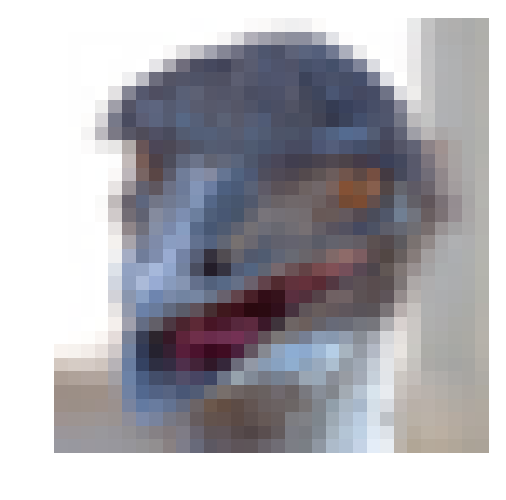

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
# Explore the dataset
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [5]:
import tensorflow as tf
import math
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0.0)


C:\Users\sohini aich\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version 1.8.0


In [6]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
# Load the preprocessed test data
test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))

In [7]:
# neural network structure for this sample:
#
# · · · · · · · · · ·          (input data, 3-deep)                    X [batch, 32, 32, 3]
# @ @ @ @ @ @ @ @ @ @       -- conv. layer +BN stride 1                W1 [8, 8, 3, 24]        B1 [24]
# :::::::::::::::                                                  Y1 [batch, 32, 32, 24]
#   @ @ @ @ @ @ @ @ @       -- conv. layer +BN stride 2                W2 [6, 6, 24, 48]       B2 [48]
#   :::::::::::::                                                  Y2 [batch, 16, 16, 48]
#     @ @ @ @ @ @ @ @       -- conv. layer +BN stride 1                W3 [4, 4, 48, 64]       B3 [64]
#     :::::::::::                                                  Y3 [batch, 16, 16, 64]
#       @ @ @ @ @ @ @       -- conv. layer +BN stride 2                W4 [3, 3, 64, 84]       B4 [84]
#       :::::::::                                                  Y4 [batch, 8, 8, 84] => reshaped to YY [batch, 8*8*84]
#     \x/x\x\x/x\      -- fully connected layer (relu+dropout+BN)      W5 [8*8*84, 200]        B5 [200]
#      ........                                                    Y5 [batch, 200]
#       \x/x\x/x\      -- fully connected layer (relu+dropout+BN)      W6 [200, 100]           B6 [100]
#        · · · ·                                                   Y6 [batch, 100]
#         /x\x/x\      -- fully connected layer (softmax)              W7 [100, 10]            B7 [10]
#          · · · ·                                                 Y [batch, 10]

In [8]:
# input X: 32x32x3 images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])

# dropout probability
pkeep = tf.placeholder(tf.float32)
pkeep_conv = tf.placeholder(tf.float32)

In [9]:
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)

def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

In [10]:
# four convolutional layers with their channel counts, and a
# two fully connected layer (tha last layer has 10 softmax neurons)
K = 24  # first convolutional layer output depth
L = 48  # second convolutional layer output depth
M = 64  # third convolutional layer
N = 84  # fourth convolutional layer
o = 200 # fully connected layer
p = 100 # fully connected layer

initializer = tf.contrib.layers.xavier_initializer_conv2d()
W1 = tf.get_variable("W1", shape=[8, 8, 3, K], initializer=initializer)    # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.get_variable("W2", shape=[6, 6, K, L], initializer=initializer)
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.get_variable("W3", shape=[4, 4, L, M], initializer=initializer)
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
W4 = tf.get_variable("W4", shape=[3, 3, M, N], initializer=initializer)
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

W5 = tf.get_variable("W5", shape=[8*8*N, o], initializer=initializer)
B5 = tf.Variable(tf.constant(0.1, tf.float32, [o]))
W6 = tf.get_variable("W6", shape=[o, p], initializer=initializer)
B6 = tf.Variable(tf.constant(0.1, tf.float32, [p]))
W7 = tf.get_variable("W7", shape=[p, 10], initializer=initializer)
B7 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

In [11]:
# batch norm scaling is not useful with relus
# batch norm offsets are used instead of biases
stride = 1
Y1l = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional=True)
Y1r = tf.nn.relu(Y1bn)
Y1 = tf.nn.dropout(Y1r, pkeep_conv)

stride = 2
Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
Y2r = tf.nn.relu(Y2bn)
Y2 = tf.nn.dropout(Y2r, pkeep_conv)

stride = 1
Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
Y3r = tf.nn.relu(Y3bn)
Y3 = tf.nn.dropout(Y3r, pkeep_conv)

stride = 2
Y4l = tf.nn.conv2d(Y3, W4, strides=[1, stride, stride, 1], padding='SAME')
Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4, convolutional=True)
Y4r = tf.nn.relu(Y4bn)
Y4 = tf.nn.dropout(Y4r, pkeep_conv)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y4, shape=[-1, 8 * 8 * N])

Y5l = tf.matmul(YY, W5)
Y5bn, update_ema5 = batchnorm(Y5l, tst, iter, B5)
Y5r = tf.nn.relu(Y5bn)
Y5 = tf.nn.dropout(Y5r, pkeep)

Y6l = tf.matmul(Y5, W6)
Y6bn, update_ema6 = batchnorm(Y6l, tst, iter, B6)
Y6r = tf.nn.relu(Y6bn)
Y6 = tf.nn.dropout(Y6r, pkeep)

Ylogits = tf.matmul(Y6, W7) + B7
Y = tf.nn.softmax(Ylogits)

update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4, update_ema5, update_ema6)


In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [13]:
# training step
# the learning rate is: # 0.00001 + 0.01 * (1/e)^(iter/17)), i.e. exponential decay from 0.01->0.00001
lr = 0.00001 +  tf.train.exponential_decay(0.01, iter, 17, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [14]:
init = tf.global_variables_initializer()

In [0]:
def train_neural_network(sess, train_step, pkeep, pkeep_conv, batch_X, batch_Y):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, iter: epoch, tst: False, pkeep: 0.6, pkeep_conv: 1.0})
    sess.run(update_ema, feed_dict={X: batch_X, Y_: batch_Y, iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})

In [15]:
def print_stats(sess, batch_X, batch_Y, cross_entropy, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc = sess.run(accuracy, feed_dict={X: valid_features, Y_: valid_labels,
                                                                        iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
    loss, l = sess.run([cross_entropy, lr], feed_dict={X: batch_X, Y_: batch_Y,
                                                                        iter: epoch, tst: False, pkeep: 1.0, pkeep_conv: 1.0})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f} with learning rate: {:.6f}'.format(loss, valid_acc, l))

In [19]:
epochs = 35
batch_size = 256

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_X, batch_Y in load_preprocess_training_batch(batch_i, batch_size):
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_stats(sess, batch_X, batch_Y, cross_entropy, accuracy)
                train_neural_network(sess, train_step, pkeep, pkeep_conv, batch_X, batch_Y)
                
    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: test_features,
        Y_: test_labels,
        iter: epochs, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
    print('Testing Accuracy: {}'.format(test_acc))



Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:   270.8988 Validation Accuracy: 0.105600 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   258.1155 Validation Accuracy: 0.152000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   230.0122 Validation Accuracy: 0.214400 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   229.0771 Validation Accuracy: 0.222400 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   207.0487 Validation Accuracy: 0.232800 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   203.2712 Validation Accuracy: 0.263800 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   202.9815 Validation Accuracy: 0.275000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   212.2305 Validation Accuracy: 0.279800 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   203.8305 Validation Accuracy: 0.283200 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 1:  Loss:   208.31

Epoch  1, CIFAR-10 Batch 3:  Loss:   146.4822 Validation Accuracy: 0.423800 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   149.0660 Validation Accuracy: 0.424800 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   146.7787 Validation Accuracy: 0.428600 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   154.4146 Validation Accuracy: 0.436400 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   142.0236 Validation Accuracy: 0.438000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   147.6592 Validation Accuracy: 0.438400 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   157.9187 Validation Accuracy: 0.437000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   146.0328 Validation Accuracy: 0.435000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   158.4009 Validation Accuracy: 0.433200 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 3:  Loss:   150.5074 Validatio

Epoch  1, CIFAR-10 Batch 5:  Loss:   134.6259 Validation Accuracy: 0.493200 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   144.1862 Validation Accuracy: 0.484200 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   133.0650 Validation Accuracy: 0.486000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   134.9279 Validation Accuracy: 0.481200 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   142.4380 Validation Accuracy: 0.485000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   139.5779 Validation Accuracy: 0.492000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   136.1427 Validation Accuracy: 0.502600 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   136.6483 Validation Accuracy: 0.499000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   135.8091 Validation Accuracy: 0.497000 with learning rate: 0.010010
Epoch  1, CIFAR-10 Batch 5:  Loss:   154.9201 Validatio

Epoch  2, CIFAR-10 Batch 3:  Loss:   127.3840 Validation Accuracy: 0.526000 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   143.3174 Validation Accuracy: 0.532600 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   128.9145 Validation Accuracy: 0.527800 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   138.9934 Validation Accuracy: 0.524600 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   125.1188 Validation Accuracy: 0.529000 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   129.1541 Validation Accuracy: 0.535200 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   128.6821 Validation Accuracy: 0.534200 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   130.7194 Validation Accuracy: 0.527400 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   121.6267 Validation Accuracy: 0.520800 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 3:  Loss:   125.9051 Validatio

Epoch  2, CIFAR-10 Batch 5:  Loss:   126.8468 Validation Accuracy: 0.554200 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   123.6149 Validation Accuracy: 0.554600 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   124.5320 Validation Accuracy: 0.553200 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   104.6750 Validation Accuracy: 0.561000 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   121.6165 Validation Accuracy: 0.567000 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   125.2966 Validation Accuracy: 0.559400 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   123.2708 Validation Accuracy: 0.560600 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   133.6682 Validation Accuracy: 0.562600 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   116.7281 Validation Accuracy: 0.568400 with learning rate: 0.009439
Epoch  2, CIFAR-10 Batch 5:  Loss:   121.3599 Validatio

Epoch  3, CIFAR-10 Batch 2:  Loss:   102.2312 Validation Accuracy: 0.605600 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 2:  Loss:   119.4931 Validation Accuracy: 0.603600 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 2:  Loss:   104.5237 Validation Accuracy: 0.606800 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 2:  Loss:   102.3230 Validation Accuracy: 0.606400 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   108.0197 Validation Accuracy: 0.603600 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   121.1710 Validation Accuracy: 0.599400 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   106.5308 Validation Accuracy: 0.599400 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   103.6708 Validation Accuracy: 0.599000 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   110.2561 Validation Accuracy: 0.599200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 3:  Loss:   116.8037 Validatio

Epoch  3, CIFAR-10 Batch 5:  Loss:   111.6656 Validation Accuracy: 0.622200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   115.0456 Validation Accuracy: 0.620200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   114.3740 Validation Accuracy: 0.619400 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   111.1930 Validation Accuracy: 0.620200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:    94.1328 Validation Accuracy: 0.622200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   100.0248 Validation Accuracy: 0.625600 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   117.0779 Validation Accuracy: 0.623800 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   102.8559 Validation Accuracy: 0.621800 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   111.3954 Validation Accuracy: 0.619200 with learning rate: 0.008900
Epoch  3, CIFAR-10 Batch 5:  Loss:   106.2549 Validatio

Epoch  4, CIFAR-10 Batch 2:  Loss:    91.1120 Validation Accuracy: 0.652000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    89.9743 Validation Accuracy: 0.650800 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    94.7254 Validation Accuracy: 0.654600 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    86.8447 Validation Accuracy: 0.656200 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    91.6032 Validation Accuracy: 0.655200 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    88.4084 Validation Accuracy: 0.654000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    97.3050 Validation Accuracy: 0.648400 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    96.0752 Validation Accuracy: 0.654000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    85.4367 Validation Accuracy: 0.654400 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 2:  Loss:    99.9795 Validatio

Epoch  4, CIFAR-10 Batch 5:  Loss:    90.5832 Validation Accuracy: 0.662600 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    98.9404 Validation Accuracy: 0.663000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    90.0029 Validation Accuracy: 0.665800 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    86.9984 Validation Accuracy: 0.670400 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    87.4818 Validation Accuracy: 0.670000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    90.9959 Validation Accuracy: 0.666600 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    88.5304 Validation Accuracy: 0.663200 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    89.5760 Validation Accuracy: 0.665600 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    92.4473 Validation Accuracy: 0.675000 with learning rate: 0.008392
Epoch  4, CIFAR-10 Batch 5:  Loss:    98.8127 Validatio

Epoch  5, CIFAR-10 Batch 2:  Loss:    90.4430 Validation Accuracy: 0.684000 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    91.6831 Validation Accuracy: 0.680600 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    75.2871 Validation Accuracy: 0.685400 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    87.7091 Validation Accuracy: 0.692200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    77.0965 Validation Accuracy: 0.692000 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    79.7862 Validation Accuracy: 0.686600 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    78.4141 Validation Accuracy: 0.684200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    79.0913 Validation Accuracy: 0.687400 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    78.8296 Validation Accuracy: 0.690400 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 2:  Loss:    78.7210 Validatio

Epoch  5, CIFAR-10 Batch 4:  Loss:    83.0816 Validation Accuracy: 0.689200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 4:  Loss:    82.2781 Validation Accuracy: 0.690600 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 4:  Loss:    76.4187 Validation Accuracy: 0.694200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 4:  Loss:    69.6388 Validation Accuracy: 0.696200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 4:  Loss:    66.8324 Validation Accuracy: 0.692200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 4:  Loss:    52.5081 Validation Accuracy: 0.683400 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 5:  Loss:    85.6455 Validation Accuracy: 0.683200 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 5:  Loss:    80.7202 Validation Accuracy: 0.688400 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 5:  Loss:    76.1833 Validation Accuracy: 0.688600 with learning rate: 0.007913
Epoch  5, CIFAR-10 Batch 5:  Loss:    84.8033 Validatio

Epoch  6, CIFAR-10 Batch 2:  Loss:    75.8115 Validation Accuracy: 0.698400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    76.3285 Validation Accuracy: 0.695400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    80.4023 Validation Accuracy: 0.692000 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    76.2688 Validation Accuracy: 0.697200 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    70.4777 Validation Accuracy: 0.701400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    65.0247 Validation Accuracy: 0.702800 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    81.1954 Validation Accuracy: 0.698400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    68.4363 Validation Accuracy: 0.694400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    74.0950 Validation Accuracy: 0.694400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 2:  Loss:    76.3397 Validatio

Epoch  6, CIFAR-10 Batch 4:  Loss:    60.4225 Validation Accuracy: 0.707400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    67.8353 Validation Accuracy: 0.707600 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    61.0589 Validation Accuracy: 0.707800 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    63.3501 Validation Accuracy: 0.709600 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    67.3400 Validation Accuracy: 0.709000 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    73.4572 Validation Accuracy: 0.709000 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    70.0340 Validation Accuracy: 0.707400 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    76.3063 Validation Accuracy: 0.706800 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    71.8126 Validation Accuracy: 0.708800 with learning rate: 0.007462
Epoch  6, CIFAR-10 Batch 4:  Loss:    70.3917 Validatio

Epoch  7, CIFAR-10 Batch 2:  Loss:    71.1842 Validation Accuracy: 0.720600 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    73.1649 Validation Accuracy: 0.714400 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    64.2328 Validation Accuracy: 0.707000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    66.3764 Validation Accuracy: 0.709000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    66.1177 Validation Accuracy: 0.713400 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    68.7000 Validation Accuracy: 0.715400 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    63.5553 Validation Accuracy: 0.710000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    62.9527 Validation Accuracy: 0.705200 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    73.6176 Validation Accuracy: 0.703800 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 2:  Loss:    72.7655 Validatio

Epoch  7, CIFAR-10 Batch 4:  Loss:    49.9138 Validation Accuracy: 0.729200 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    63.3644 Validation Accuracy: 0.728400 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    48.4503 Validation Accuracy: 0.725600 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    60.1243 Validation Accuracy: 0.723000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    66.1718 Validation Accuracy: 0.720400 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    58.0478 Validation Accuracy: 0.720000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    58.1425 Validation Accuracy: 0.722600 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    56.2623 Validation Accuracy: 0.726000 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    46.5912 Validation Accuracy: 0.724800 with learning rate: 0.007036
Epoch  7, CIFAR-10 Batch 4:  Loss:    58.5847 Validatio

Epoch  8, CIFAR-10 Batch 1:  Loss:    48.5821 Validation Accuracy: 0.735400 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    46.0553 Validation Accuracy: 0.734800 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    52.4777 Validation Accuracy: 0.730200 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    57.8550 Validation Accuracy: 0.730600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    48.0087 Validation Accuracy: 0.731800 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    53.7226 Validation Accuracy: 0.731800 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    46.9616 Validation Accuracy: 0.733600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 1:  Loss:    17.4510 Validation Accuracy: 0.737200 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 2:  Loss:    51.6684 Validation Accuracy: 0.731000 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 2:  Loss:    57.9700 Validatio

Epoch  8, CIFAR-10 Batch 4:  Loss:    47.8880 Validation Accuracy: 0.720600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    50.0691 Validation Accuracy: 0.717800 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    51.6244 Validation Accuracy: 0.721600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    47.4087 Validation Accuracy: 0.723800 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    43.2254 Validation Accuracy: 0.728200 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    50.9758 Validation Accuracy: 0.725600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    52.4540 Validation Accuracy: 0.722400 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    58.3080 Validation Accuracy: 0.720200 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    44.4915 Validation Accuracy: 0.719600 with learning rate: 0.006635
Epoch  8, CIFAR-10 Batch 4:  Loss:    49.7347 Validatio

Epoch  9, CIFAR-10 Batch 1:  Loss:    45.1516 Validation Accuracy: 0.736400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    46.1489 Validation Accuracy: 0.734000 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    43.0422 Validation Accuracy: 0.732400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    37.4444 Validation Accuracy: 0.735400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    40.3173 Validation Accuracy: 0.738800 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    45.9060 Validation Accuracy: 0.739400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    42.0727 Validation Accuracy: 0.739400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    47.7905 Validation Accuracy: 0.739600 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    41.5954 Validation Accuracy: 0.737400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 1:  Loss:    39.3587 Validatio

Epoch  9, CIFAR-10 Batch 3:  Loss:    39.3989 Validation Accuracy: 0.741200 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 3:  Loss:    10.1840 Validation Accuracy: 0.744200 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    43.3376 Validation Accuracy: 0.741600 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    36.1421 Validation Accuracy: 0.739200 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    44.5620 Validation Accuracy: 0.738800 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    37.5042 Validation Accuracy: 0.738000 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    37.6882 Validation Accuracy: 0.739400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    39.2481 Validation Accuracy: 0.740200 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    38.2287 Validation Accuracy: 0.738400 with learning rate: 0.006256
Epoch  9, CIFAR-10 Batch 4:  Loss:    39.0700 Validatio

Epoch 10, CIFAR-10 Batch 1:  Loss:    39.6955 Validation Accuracy: 0.746000 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    36.1147 Validation Accuracy: 0.749200 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    30.2396 Validation Accuracy: 0.746800 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    28.9578 Validation Accuracy: 0.744800 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    27.6778 Validation Accuracy: 0.743000 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    35.5364 Validation Accuracy: 0.745400 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    28.5025 Validation Accuracy: 0.746200 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    37.8236 Validation Accuracy: 0.743600 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    32.4618 Validation Accuracy: 0.744400 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 1:  Loss:    40.1343 Validatio

Epoch 10, CIFAR-10 Batch 3:  Loss:    38.7413 Validation Accuracy: 0.728200 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    39.8649 Validation Accuracy: 0.730600 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    39.1132 Validation Accuracy: 0.731000 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    32.8315 Validation Accuracy: 0.728600 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    33.6988 Validation Accuracy: 0.728800 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    35.5108 Validation Accuracy: 0.731400 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    29.9952 Validation Accuracy: 0.731000 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    35.9192 Validation Accuracy: 0.734600 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:    28.3511 Validation Accuracy: 0.732800 with learning rate: 0.005900
Epoch 10, CIFAR-10 Batch 3:  Loss:     7.0350 Validatio

Epoch 11, CIFAR-10 Batch 1:  Loss:    29.6826 Validation Accuracy: 0.742600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    28.8792 Validation Accuracy: 0.744600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    27.7578 Validation Accuracy: 0.745400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    33.7055 Validation Accuracy: 0.746200 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    23.3715 Validation Accuracy: 0.745800 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    21.6932 Validation Accuracy: 0.745000 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    26.7487 Validation Accuracy: 0.743400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    26.9315 Validation Accuracy: 0.745400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    29.0268 Validation Accuracy: 0.739600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 1:  Loss:    30.0877 Validatio

Epoch 11, CIFAR-10 Batch 3:  Loss:    33.9804 Validation Accuracy: 0.731200 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    26.4159 Validation Accuracy: 0.730400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    26.1517 Validation Accuracy: 0.726000 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    25.5797 Validation Accuracy: 0.721200 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    35.0922 Validation Accuracy: 0.718400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    27.3794 Validation Accuracy: 0.717800 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    22.6891 Validation Accuracy: 0.722800 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    28.7924 Validation Accuracy: 0.725600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    35.7383 Validation Accuracy: 0.726400 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 3:  Loss:    34.7125 Validatio

Epoch 11, CIFAR-10 Batch 5:  Loss:    21.9575 Validation Accuracy: 0.740200 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 5:  Loss:    20.5981 Validation Accuracy: 0.740600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 5:  Loss:    25.0491 Validation Accuracy: 0.742600 with learning rate: 0.005563
Epoch 11, CIFAR-10 Batch 5:  Loss:     1.2964 Validation Accuracy: 0.741000 with learning rate: 0.005563
Epoch 12, CIFAR-10 Batch 1:  Loss:    22.3533 Validation Accuracy: 0.736200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 1:  Loss:    19.8166 Validation Accuracy: 0.732800 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 1:  Loss:    20.9200 Validation Accuracy: 0.731000 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 1:  Loss:    24.0515 Validation Accuracy: 0.731200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 1:  Loss:    28.2608 Validation Accuracy: 0.735800 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 1:  Loss:    23.0781 Validatio

Epoch 12, CIFAR-10 Batch 3:  Loss:    23.4737 Validation Accuracy: 0.742600 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    23.7749 Validation Accuracy: 0.741400 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    19.6534 Validation Accuracy: 0.738600 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    22.4644 Validation Accuracy: 0.737200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    23.0166 Validation Accuracy: 0.739200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    21.4908 Validation Accuracy: 0.740800 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    27.7987 Validation Accuracy: 0.741600 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    26.1190 Validation Accuracy: 0.742400 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    21.1498 Validation Accuracy: 0.741400 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 3:  Loss:    17.1940 Validatio

Epoch 12, CIFAR-10 Batch 5:  Loss:    25.7198 Validation Accuracy: 0.737200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    22.9240 Validation Accuracy: 0.738200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    13.8524 Validation Accuracy: 0.739000 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    18.9013 Validation Accuracy: 0.741200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    15.2757 Validation Accuracy: 0.741200 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    16.9431 Validation Accuracy: 0.741400 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    24.2842 Validation Accuracy: 0.742800 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    18.6968 Validation Accuracy: 0.742000 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    15.7348 Validation Accuracy: 0.742400 with learning rate: 0.005246
Epoch 12, CIFAR-10 Batch 5:  Loss:    14.8609 Validatio

Epoch 13, CIFAR-10 Batch 3:  Loss:    20.5324 Validation Accuracy: 0.746200 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    14.2396 Validation Accuracy: 0.746800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    19.3694 Validation Accuracy: 0.745800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    15.6110 Validation Accuracy: 0.746400 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    19.8355 Validation Accuracy: 0.744600 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    20.4228 Validation Accuracy: 0.743600 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    13.0705 Validation Accuracy: 0.744800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    21.6333 Validation Accuracy: 0.748400 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    18.2854 Validation Accuracy: 0.748000 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 3:  Loss:    18.0425 Validatio

Epoch 13, CIFAR-10 Batch 5:  Loss:    15.8194 Validation Accuracy: 0.739800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:     9.2503 Validation Accuracy: 0.744400 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    16.7306 Validation Accuracy: 0.744800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    20.1216 Validation Accuracy: 0.749000 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:     9.6688 Validation Accuracy: 0.746200 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    10.4097 Validation Accuracy: 0.745000 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    10.8985 Validation Accuracy: 0.742600 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    15.4550 Validation Accuracy: 0.739000 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    16.5851 Validation Accuracy: 0.738800 with learning rate: 0.004947
Epoch 13, CIFAR-10 Batch 5:  Loss:    19.5725 Validatio

Epoch 14, CIFAR-10 Batch 2:  Loss:    14.1661 Validation Accuracy: 0.742000 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 2:  Loss:    17.3350 Validation Accuracy: 0.743200 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 2:  Loss:     9.7035 Validation Accuracy: 0.745800 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 2:  Loss:    12.3829 Validation Accuracy: 0.745400 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 2:  Loss:     7.7633 Validation Accuracy: 0.745600 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 2:  Loss:     1.0265 Validation Accuracy: 0.747800 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 3:  Loss:    11.0146 Validation Accuracy: 0.747400 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 3:  Loss:    10.6625 Validation Accuracy: 0.744600 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 3:  Loss:    12.9682 Validation Accuracy: 0.747800 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 3:  Loss:    11.5805 Validatio

Epoch 14, CIFAR-10 Batch 5:  Loss:    13.6208 Validation Accuracy: 0.742800 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:    12.2115 Validation Accuracy: 0.746000 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:    12.5094 Validation Accuracy: 0.747200 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:    13.5770 Validation Accuracy: 0.744600 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:     9.7523 Validation Accuracy: 0.745000 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:    10.6558 Validation Accuracy: 0.743800 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:     9.6717 Validation Accuracy: 0.740400 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:     7.6312 Validation Accuracy: 0.739000 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:    10.8232 Validation Accuracy: 0.737200 with learning rate: 0.004665
Epoch 14, CIFAR-10 Batch 5:  Loss:     6.7326 Validatio

Epoch 15, CIFAR-10 Batch 2:  Loss:     7.5579 Validation Accuracy: 0.748200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:     7.9427 Validation Accuracy: 0.748800 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:     6.4820 Validation Accuracy: 0.749200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:    12.3047 Validation Accuracy: 0.749200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:    11.1088 Validation Accuracy: 0.750000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:     9.9321 Validation Accuracy: 0.747400 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:    12.9749 Validation Accuracy: 0.747200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:    11.8965 Validation Accuracy: 0.749000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:     9.9823 Validation Accuracy: 0.749000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 2:  Loss:    10.9719 Validatio

Epoch 15, CIFAR-10 Batch 5:  Loss:     8.4019 Validation Accuracy: 0.742000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     7.9509 Validation Accuracy: 0.739400 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     6.0408 Validation Accuracy: 0.741000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     8.9914 Validation Accuracy: 0.743000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     5.7945 Validation Accuracy: 0.743000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     7.4731 Validation Accuracy: 0.743000 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     8.2451 Validation Accuracy: 0.746400 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     7.7235 Validation Accuracy: 0.747200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:     8.6193 Validation Accuracy: 0.745200 with learning rate: 0.004399
Epoch 15, CIFAR-10 Batch 5:  Loss:    10.5132 Validatio

Epoch 16, CIFAR-10 Batch 2:  Loss:     9.0616 Validation Accuracy: 0.748200 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     6.0017 Validation Accuracy: 0.750000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     9.5047 Validation Accuracy: 0.748000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     5.0909 Validation Accuracy: 0.749000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     5.5909 Validation Accuracy: 0.751200 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     7.1661 Validation Accuracy: 0.751200 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     7.8303 Validation Accuracy: 0.751600 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     8.5230 Validation Accuracy: 0.752000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     7.8168 Validation Accuracy: 0.755400 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 2:  Loss:     5.0404 Validatio

Epoch 16, CIFAR-10 Batch 4:  Loss:     6.7385 Validation Accuracy: 0.745800 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     6.6391 Validation Accuracy: 0.746000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     5.5257 Validation Accuracy: 0.743400 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     7.1111 Validation Accuracy: 0.742000 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     7.4361 Validation Accuracy: 0.740600 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     3.2558 Validation Accuracy: 0.741800 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     3.2619 Validation Accuracy: 0.739400 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 4:  Loss:     0.2331 Validation Accuracy: 0.740800 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 5:  Loss:     6.9124 Validation Accuracy: 0.742800 with learning rate: 0.004148
Epoch 16, CIFAR-10 Batch 5:  Loss:     7.7226 Validatio

Epoch 17, CIFAR-10 Batch 2:  Loss:     5.6346 Validation Accuracy: 0.747600 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     7.1201 Validation Accuracy: 0.746800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     3.9949 Validation Accuracy: 0.746800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     5.0158 Validation Accuracy: 0.745800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     5.2999 Validation Accuracy: 0.744600 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     4.5496 Validation Accuracy: 0.744000 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     6.2097 Validation Accuracy: 0.742800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     6.7496 Validation Accuracy: 0.745600 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     5.7559 Validation Accuracy: 0.746000 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 2:  Loss:     7.4949 Validatio

Epoch 17, CIFAR-10 Batch 4:  Loss:     5.7768 Validation Accuracy: 0.749200 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     4.8032 Validation Accuracy: 0.752600 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     4.9242 Validation Accuracy: 0.750800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     4.6545 Validation Accuracy: 0.749600 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     6.8107 Validation Accuracy: 0.748800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     6.4942 Validation Accuracy: 0.748800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     3.2909 Validation Accuracy: 0.748000 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     5.6417 Validation Accuracy: 0.750000 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     7.0855 Validation Accuracy: 0.752800 with learning rate: 0.003912
Epoch 17, CIFAR-10 Batch 4:  Loss:     4.4185 Validatio

Epoch 18, CIFAR-10 Batch 1:  Loss:     4.3375 Validation Accuracy: 0.751600 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 1:  Loss:     0.4714 Validation Accuracy: 0.753800 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     2.6520 Validation Accuracy: 0.754800 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     3.9311 Validation Accuracy: 0.751000 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     3.9559 Validation Accuracy: 0.751400 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     4.4434 Validation Accuracy: 0.750200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     2.6792 Validation Accuracy: 0.751200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     5.4805 Validation Accuracy: 0.751200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     6.8218 Validation Accuracy: 0.750600 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 2:  Loss:     5.4870 Validatio

Epoch 18, CIFAR-10 Batch 4:  Loss:     2.2624 Validation Accuracy: 0.752600 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     3.1951 Validation Accuracy: 0.752200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     2.1198 Validation Accuracy: 0.750400 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     3.5632 Validation Accuracy: 0.749200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     3.1938 Validation Accuracy: 0.748400 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     4.2071 Validation Accuracy: 0.748400 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     7.2654 Validation Accuracy: 0.748200 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     3.5588 Validation Accuracy: 0.750800 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     4.4504 Validation Accuracy: 0.752400 with learning rate: 0.003689
Epoch 18, CIFAR-10 Batch 4:  Loss:     6.1169 Validatio

Epoch 19, CIFAR-10 Batch 1:  Loss:     1.9703 Validation Accuracy: 0.751000 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     3.0147 Validation Accuracy: 0.751200 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     2.0668 Validation Accuracy: 0.750600 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     4.4261 Validation Accuracy: 0.750000 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     3.9443 Validation Accuracy: 0.751000 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     3.9464 Validation Accuracy: 0.751200 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     4.6645 Validation Accuracy: 0.750400 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     4.4388 Validation Accuracy: 0.751400 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     4.1556 Validation Accuracy: 0.753000 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 1:  Loss:     0.2155 Validatio

Epoch 19, CIFAR-10 Batch 4:  Loss:     1.8914 Validation Accuracy: 0.753200 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     4.0010 Validation Accuracy: 0.752800 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     2.6893 Validation Accuracy: 0.754400 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     2.7422 Validation Accuracy: 0.755600 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     2.5087 Validation Accuracy: 0.754800 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     2.7227 Validation Accuracy: 0.753600 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     4.0793 Validation Accuracy: 0.754600 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     2.3733 Validation Accuracy: 0.756400 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     3.8690 Validation Accuracy: 0.756400 with learning rate: 0.003479
Epoch 19, CIFAR-10 Batch 4:  Loss:     4.3115 Validatio

Epoch 20, CIFAR-10 Batch 1:  Loss:     2.8695 Validation Accuracy: 0.752000 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     2.3825 Validation Accuracy: 0.750800 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     3.0898 Validation Accuracy: 0.753800 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     3.5473 Validation Accuracy: 0.752400 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     3.2197 Validation Accuracy: 0.753600 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     2.4877 Validation Accuracy: 0.755600 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     2.7652 Validation Accuracy: 0.757000 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     2.0581 Validation Accuracy: 0.757800 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     3.0500 Validation Accuracy: 0.757800 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 1:  Loss:     2.1227 Validatio

Epoch 20, CIFAR-10 Batch 3:  Loss:     2.0236 Validation Accuracy: 0.747200 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 3:  Loss:     2.3716 Validation Accuracy: 0.747000 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 3:  Loss:     3.2506 Validation Accuracy: 0.747000 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 3:  Loss:     0.1571 Validation Accuracy: 0.746800 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     3.8350 Validation Accuracy: 0.746600 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     1.5300 Validation Accuracy: 0.747000 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     3.1811 Validation Accuracy: 0.747200 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     3.1870 Validation Accuracy: 0.747600 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     1.4132 Validation Accuracy: 0.748200 with learning rate: 0.003280
Epoch 20, CIFAR-10 Batch 4:  Loss:     2.7070 Validatio

Epoch 21, CIFAR-10 Batch 1:  Loss:     1.3838 Validation Accuracy: 0.744800 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.5971 Validation Accuracy: 0.744200 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     2.6161 Validation Accuracy: 0.745800 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.3443 Validation Accuracy: 0.746000 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.1473 Validation Accuracy: 0.745200 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     2.3508 Validation Accuracy: 0.744400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.9497 Validation Accuracy: 0.746000 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     2.8521 Validation Accuracy: 0.748000 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     1.4867 Validation Accuracy: 0.749200 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 1:  Loss:     3.9646 Validatio

Epoch 21, CIFAR-10 Batch 3:  Loss:     0.9721 Validation Accuracy: 0.758400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.2962 Validation Accuracy: 0.756400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.9605 Validation Accuracy: 0.756000 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.8670 Validation Accuracy: 0.754400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     0.9852 Validation Accuracy: 0.752800 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.1438 Validation Accuracy: 0.753800 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     0.9693 Validation Accuracy: 0.755400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.6205 Validation Accuracy: 0.755800 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     1.6793 Validation Accuracy: 0.756400 with learning rate: 0.003094
Epoch 21, CIFAR-10 Batch 3:  Loss:     2.6348 Validatio

Epoch 22, CIFAR-10 Batch 1:  Loss:     1.4309 Validation Accuracy: 0.750000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     2.5022 Validation Accuracy: 0.749600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     4.0642 Validation Accuracy: 0.750000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     2.5531 Validation Accuracy: 0.748000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     2.6385 Validation Accuracy: 0.747000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.1086 Validation Accuracy: 0.749000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.4074 Validation Accuracy: 0.749000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.4462 Validation Accuracy: 0.749600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.4133 Validation Accuracy: 0.750600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 1:  Loss:     1.0640 Validatio

Epoch 22, CIFAR-10 Batch 3:  Loss:     1.3533 Validation Accuracy: 0.761200 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     1.0186 Validation Accuracy: 0.760600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     0.8703 Validation Accuracy: 0.761200 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     1.3962 Validation Accuracy: 0.760200 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     0.9317 Validation Accuracy: 0.759600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     1.7016 Validation Accuracy: 0.758800 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     1.1828 Validation Accuracy: 0.756000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     0.8825 Validation Accuracy: 0.755200 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     0.7788 Validation Accuracy: 0.755400 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 3:  Loss:     2.4486 Validatio

Epoch 22, CIFAR-10 Batch 5:  Loss:     1.2932 Validation Accuracy: 0.755000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 5:  Loss:     1.4572 Validation Accuracy: 0.754600 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.8949 Validation Accuracy: 0.756000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.4464 Validation Accuracy: 0.755000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.7975 Validation Accuracy: 0.754000 with learning rate: 0.002917
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.0062 Validation Accuracy: 0.750800 with learning rate: 0.002917
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.6243 Validation Accuracy: 0.749600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.5444 Validation Accuracy: 0.747200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.5042 Validation Accuracy: 0.744000 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.7667 Validatio

Epoch 23, CIFAR-10 Batch 3:  Loss:     0.9140 Validation Accuracy: 0.744600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.1238 Validation Accuracy: 0.745200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.3894 Validation Accuracy: 0.747800 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.8323 Validation Accuracy: 0.750800 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.4370 Validation Accuracy: 0.748600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.2019 Validation Accuracy: 0.749000 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.7409 Validation Accuracy: 0.749200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     2.7844 Validation Accuracy: 0.749200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.1769 Validation Accuracy: 0.748200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.4539 Validatio

Epoch 23, CIFAR-10 Batch 5:  Loss:     0.5535 Validation Accuracy: 0.754600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     1.4008 Validation Accuracy: 0.754600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.8557 Validation Accuracy: 0.753400 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     1.9690 Validation Accuracy: 0.751600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.6616 Validation Accuracy: 0.752800 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     2.5807 Validation Accuracy: 0.752200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     1.5650 Validation Accuracy: 0.753200 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.5265 Validation Accuracy: 0.753600 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.7814 Validation Accuracy: 0.753800 with learning rate: 0.002751
Epoch 23, CIFAR-10 Batch 5:  Loss:     2.3679 Validatio

Epoch 24, CIFAR-10 Batch 3:  Loss:     0.8360 Validation Accuracy: 0.758600 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     1.1057 Validation Accuracy: 0.759800 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     1.3453 Validation Accuracy: 0.760200 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.6005 Validation Accuracy: 0.759200 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.6370 Validation Accuracy: 0.756800 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.3708 Validation Accuracy: 0.756000 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.4390 Validation Accuracy: 0.757400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.6314 Validation Accuracy: 0.756800 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.3541 Validation Accuracy: 0.756400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.3072 Validatio

Epoch 24, CIFAR-10 Batch 5:  Loss:     0.4796 Validation Accuracy: 0.755400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.6448 Validation Accuracy: 0.756200 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.3976 Validation Accuracy: 0.757400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.8601 Validation Accuracy: 0.756400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.3891 Validation Accuracy: 0.754600 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     1.1485 Validation Accuracy: 0.754000 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.3792 Validation Accuracy: 0.753600 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.4068 Validation Accuracy: 0.753400 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.4857 Validation Accuracy: 0.753000 with learning rate: 0.002595
Epoch 24, CIFAR-10 Batch 5:  Loss:     1.2588 Validatio

Epoch 25, CIFAR-10 Batch 2:  Loss:     1.8022 Validation Accuracy: 0.756600 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     1.1292 Validation Accuracy: 0.755000 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.5335 Validation Accuracy: 0.754800 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.4841 Validation Accuracy: 0.755000 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.2962 Validation Accuracy: 0.755400 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.6599 Validation Accuracy: 0.755000 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.2239 Validation Accuracy: 0.754800 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.0208 Validation Accuracy: 0.754400 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 3:  Loss:     0.4224 Validation Accuracy: 0.753600 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 3:  Loss:     1.1638 Validatio

Epoch 25, CIFAR-10 Batch 5:  Loss:     1.4301 Validation Accuracy: 0.756600 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     1.2157 Validation Accuracy: 0.756000 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.4282 Validation Accuracy: 0.756000 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.4794 Validation Accuracy: 0.755600 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.8922 Validation Accuracy: 0.755200 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.2492 Validation Accuracy: 0.754400 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.4584 Validation Accuracy: 0.756200 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.4987 Validation Accuracy: 0.755400 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.3875 Validation Accuracy: 0.754600 with learning rate: 0.002447
Epoch 25, CIFAR-10 Batch 5:  Loss:     0.5682 Validatio

Epoch 26, CIFAR-10 Batch 2:  Loss:     0.4250 Validation Accuracy: 0.757200 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.4866 Validation Accuracy: 0.757600 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.4039 Validation Accuracy: 0.758600 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.1885 Validation Accuracy: 0.758400 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.2221 Validation Accuracy: 0.759000 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.9796 Validation Accuracy: 0.760600 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.2847 Validation Accuracy: 0.761200 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.5355 Validation Accuracy: 0.760600 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     1.5820 Validation Accuracy: 0.760600 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 2:  Loss:     0.3656 Validatio

Epoch 26, CIFAR-10 Batch 4:  Loss:     0.5261 Validation Accuracy: 0.760400 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 4:  Loss:     0.0116 Validation Accuracy: 0.761000 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.2715 Validation Accuracy: 0.760800 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.4733 Validation Accuracy: 0.759800 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.4741 Validation Accuracy: 0.759200 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.3482 Validation Accuracy: 0.758000 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.2394 Validation Accuracy: 0.758000 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.4031 Validation Accuracy: 0.756800 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.2454 Validation Accuracy: 0.757000 with learning rate: 0.002308
Epoch 26, CIFAR-10 Batch 5:  Loss:     0.2023 Validatio

Epoch 27, CIFAR-10 Batch 2:  Loss:     0.8337 Validation Accuracy: 0.756200 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.1616 Validation Accuracy: 0.758000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.3065 Validation Accuracy: 0.760000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.8032 Validation Accuracy: 0.760400 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.5436 Validation Accuracy: 0.758200 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.3326 Validation Accuracy: 0.758000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.9076 Validation Accuracy: 0.756800 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.4958 Validation Accuracy: 0.756600 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.6328 Validation Accuracy: 0.756200 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 2:  Loss:     0.2734 Validatio

Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2026 Validation Accuracy: 0.757000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.1918 Validation Accuracy: 0.756400 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2376 Validation Accuracy: 0.756400 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2972 Validation Accuracy: 0.756400 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2288 Validation Accuracy: 0.754000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.4425 Validation Accuracy: 0.755000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2378 Validation Accuracy: 0.756000 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2319 Validation Accuracy: 0.755600 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.1562 Validation Accuracy: 0.755200 with learning rate: 0.002177
Epoch 27, CIFAR-10 Batch 5:  Loss:     0.2607 Validatio

Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2171 Validation Accuracy: 0.759600 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2387 Validation Accuracy: 0.759200 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2659 Validation Accuracy: 0.758600 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2630 Validation Accuracy: 0.759000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2201 Validation Accuracy: 0.759000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.1896 Validation Accuracy: 0.760000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2740 Validation Accuracy: 0.760000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.4445 Validation Accuracy: 0.759800 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.2554 Validation Accuracy: 0.759400 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 2:  Loss:     0.1812 Validatio

Epoch 28, CIFAR-10 Batch 4:  Loss:     0.6088 Validation Accuracy: 0.758200 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.9858 Validation Accuracy: 0.759000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.4282 Validation Accuracy: 0.758000 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.5025 Validation Accuracy: 0.758200 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.1677 Validation Accuracy: 0.755800 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.1360 Validation Accuracy: 0.755800 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.2558 Validation Accuracy: 0.756600 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 4:  Loss:     0.0078 Validation Accuracy: 0.755400 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 5:  Loss:     0.2591 Validation Accuracy: 0.755600 with learning rate: 0.002053
Epoch 28, CIFAR-10 Batch 5:  Loss:     0.4832 Validatio

Epoch 29, CIFAR-10 Batch 2:  Loss:     0.5950 Validation Accuracy: 0.757800 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2505 Validation Accuracy: 0.758200 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.3191 Validation Accuracy: 0.758600 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2306 Validation Accuracy: 0.758400 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2171 Validation Accuracy: 0.757600 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2451 Validation Accuracy: 0.759000 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.4666 Validation Accuracy: 0.758000 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2336 Validation Accuracy: 0.757200 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.2722 Validation Accuracy: 0.756800 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 2:  Loss:     0.4272 Validatio

Epoch 29, CIFAR-10 Batch 4:  Loss:     0.3490 Validation Accuracy: 0.757800 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.1510 Validation Accuracy: 0.759200 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.1049 Validation Accuracy: 0.759200 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.0999 Validation Accuracy: 0.762000 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.2757 Validation Accuracy: 0.762000 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     1.1484 Validation Accuracy: 0.762600 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.1357 Validation Accuracy: 0.761800 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.1590 Validation Accuracy: 0.761400 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.2504 Validation Accuracy: 0.761000 with learning rate: 0.001936
Epoch 29, CIFAR-10 Batch 4:  Loss:     0.9901 Validatio

Epoch 30, CIFAR-10 Batch 1:  Loss:     0.2468 Validation Accuracy: 0.759800 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 1:  Loss:     0.0074 Validation Accuracy: 0.759400 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1270 Validation Accuracy: 0.760600 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1442 Validation Accuracy: 0.760200 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.2191 Validation Accuracy: 0.759400 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1578 Validation Accuracy: 0.759200 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.0981 Validation Accuracy: 0.759800 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1435 Validation Accuracy: 0.758000 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.4142 Validation Accuracy: 0.759000 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1682 Validatio

Epoch 30, CIFAR-10 Batch 4:  Loss:     0.1698 Validation Accuracy: 0.753600 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.2379 Validation Accuracy: 0.752400 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.1604 Validation Accuracy: 0.752600 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.2590 Validation Accuracy: 0.752200 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.1182 Validation Accuracy: 0.751800 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.2024 Validation Accuracy: 0.752600 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.0630 Validation Accuracy: 0.753400 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.2314 Validation Accuracy: 0.754400 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.3831 Validation Accuracy: 0.754600 with learning rate: 0.001826
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.2017 Validatio

Epoch 31, CIFAR-10 Batch 1:  Loss:     0.0971 Validation Accuracy: 0.756400 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.1674 Validation Accuracy: 0.756400 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.1082 Validation Accuracy: 0.757000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.1843 Validation Accuracy: 0.758000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.1636 Validation Accuracy: 0.757800 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.2290 Validation Accuracy: 0.757800 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.4003 Validation Accuracy: 0.757000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.2636 Validation Accuracy: 0.757400 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.1015 Validation Accuracy: 0.756400 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.0044 Validatio

Epoch 31, CIFAR-10 Batch 4:  Loss:     0.1346 Validation Accuracy: 0.756000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.1980 Validation Accuracy: 0.755000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0654 Validation Accuracy: 0.755000 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.1061 Validation Accuracy: 0.754600 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.2271 Validation Accuracy: 0.756200 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0936 Validation Accuracy: 0.755600 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0701 Validation Accuracy: 0.755200 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0714 Validation Accuracy: 0.755200 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0945 Validation Accuracy: 0.754400 with learning rate: 0.001722
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.3094 Validatio

Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0665 Validation Accuracy: 0.759000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.2270 Validation Accuracy: 0.760600 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.1475 Validation Accuracy: 0.761400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0654 Validation Accuracy: 0.760000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.2874 Validation Accuracy: 0.759000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.1282 Validation Accuracy: 0.759000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0854 Validation Accuracy: 0.759400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.1834 Validation Accuracy: 0.759400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0975 Validation Accuracy: 0.759800 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.1044 Validatio

Epoch 32, CIFAR-10 Batch 3:  Loss:     0.0826 Validation Accuracy: 0.758000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 3:  Loss:     0.1687 Validation Accuracy: 0.757600 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 3:  Loss:     0.0901 Validation Accuracy: 0.757600 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 3:  Loss:     0.0047 Validation Accuracy: 0.757400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.3543 Validation Accuracy: 0.757200 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.0510 Validation Accuracy: 0.756400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.1705 Validation Accuracy: 0.755800 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.3161 Validation Accuracy: 0.754400 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.1135 Validation Accuracy: 0.755000 with learning rate: 0.001625
Epoch 32, CIFAR-10 Batch 4:  Loss:     0.5371 Validatio

Epoch 33, CIFAR-10 Batch 1:  Loss:     0.1096 Validation Accuracy: 0.755000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.2398 Validation Accuracy: 0.755400 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.6479 Validation Accuracy: 0.756200 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.1264 Validation Accuracy: 0.755400 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.0894 Validation Accuracy: 0.756000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.1124 Validation Accuracy: 0.755600 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.0623 Validation Accuracy: 0.755400 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.1335 Validation Accuracy: 0.755200 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.0494 Validation Accuracy: 0.756600 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 1:  Loss:     0.1548 Validatio

Epoch 33, CIFAR-10 Batch 3:  Loss:     0.1176 Validation Accuracy: 0.761200 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.3058 Validation Accuracy: 0.760800 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0565 Validation Accuracy: 0.760200 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.1449 Validation Accuracy: 0.759000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0593 Validation Accuracy: 0.759000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0658 Validation Accuracy: 0.757600 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0324 Validation Accuracy: 0.757200 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0649 Validation Accuracy: 0.758000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0651 Validation Accuracy: 0.758000 with learning rate: 0.001532
Epoch 33, CIFAR-10 Batch 3:  Loss:     0.0751 Validatio

Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0321 Validation Accuracy: 0.756800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0629 Validation Accuracy: 0.758000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.1210 Validation Accuracy: 0.757600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.8113 Validation Accuracy: 0.758800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0515 Validation Accuracy: 0.757800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0827 Validation Accuracy: 0.756600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0391 Validation Accuracy: 0.756000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0484 Validation Accuracy: 0.756000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.1067 Validation Accuracy: 0.755000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 1:  Loss:     0.0764 Validatio

Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0618 Validation Accuracy: 0.754800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.1153 Validation Accuracy: 0.754600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.1233 Validation Accuracy: 0.752400 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0534 Validation Accuracy: 0.752600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0916 Validation Accuracy: 0.752200 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0955 Validation Accuracy: 0.753000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0728 Validation Accuracy: 0.753600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0778 Validation Accuracy: 0.754000 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.0726 Validation Accuracy: 0.753800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 3:  Loss:     0.3926 Validatio

Epoch 34, CIFAR-10 Batch 5:  Loss:     0.0663 Validation Accuracy: 0.754800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 5:  Loss:     0.0548 Validation Accuracy: 0.755600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 5:  Loss:     0.2645 Validation Accuracy: 0.755600 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 5:  Loss:     0.0392 Validation Accuracy: 0.754800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 5:  Loss:     0.0613 Validation Accuracy: 0.754800 with learning rate: 0.001445
Epoch 34, CIFAR-10 Batch 5:  Loss:     0.0079 Validation Accuracy: 0.755800 with learning rate: 0.001445
Epoch 35, CIFAR-10 Batch 1:  Loss:     0.1810 Validation Accuracy: 0.756000 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 1:  Loss:     0.0297 Validation Accuracy: 0.755800 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 1:  Loss:     0.0406 Validation Accuracy: 0.755600 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 1:  Loss:     0.0598 Validatio

Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0531 Validation Accuracy: 0.752600 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0653 Validation Accuracy: 0.754200 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0477 Validation Accuracy: 0.754400 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0603 Validation Accuracy: 0.754200 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0617 Validation Accuracy: 0.754600 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0630 Validation Accuracy: 0.753600 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0308 Validation Accuracy: 0.754000 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.1114 Validation Accuracy: 0.754000 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.0467 Validation Accuracy: 0.754000 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 3:  Loss:     0.1514 Validatio

Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0294 Validation Accuracy: 0.759400 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0905 Validation Accuracy: 0.759200 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0333 Validation Accuracy: 0.758400 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0429 Validation Accuracy: 0.758200 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0535 Validation Accuracy: 0.758000 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0597 Validation Accuracy: 0.756600 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.1208 Validation Accuracy: 0.756800 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.1057 Validation Accuracy: 0.756400 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0497 Validation Accuracy: 0.755400 with learning rate: 0.001363
Epoch 35, CIFAR-10 Batch 5:  Loss:     0.0784 Validatio

After 35 Epoch, we gets the validation accuracy of 75% and test accuracy 75%..